# 🚀 Analyse des Consommations Énergétique en Bretagne

## **Contexte**
Dans ce projet, nous analysons les données liées aux logements en Bretagne pour mieux comprendre leur consommation énergétique et identifier des pistes d'amélioration. L'objectif est d'évaluer les coûts énergétiques et leur relation avec les caractéristiques des logements.



##  Préparation des Données
- **Chargement des données** :
  - `logements_neufs.csv` : Données des nouveaux logements.
  - `logements_existants.csv` : Données des logements existants.
  
  

In [138]:
import pandas as pd
from preprocessing_function import *
import warnings
warnings.filterwarnings('ignore')

logements_neufs = pd.read_csv('data/raw/neufs.csv')
logements_existants = pd.read_csv('data/raw/existents.csv')

In [140]:
print(logements_neufs.shape)
print(logements_existants.shape)

(59213, 135)
(398114, 235)


On peut remarquer que les datasets contiennent énormément de données et de variables. Nous avons supprimé les variables contenant beaucoup de données manquantes, 

La colonne **Logement** a été ajouté aux dataframes pour distinguer les logements existants des neufs. Nous avons aussi remarqué que les logements neufs ne disposent pas de la colonne **Année_cnstruction** que nous pensons utile pour la modélisation.



In [ ]:
import numpy as np

# Pour les anciens
logements_existants["Logement"] = "ancien"
distribution = logements_existants['Année_construction'].value_counts(normalize=True)

# Remplacer les valeurs manquantes en tirant aléatoirement basé sur la distribution
logements_existants['Année_construction'] = logements_existants['Année_construction'].apply(
    lambda x: np.random.choice(distribution.index, p=distribution.values) if pd.isnull(x) else x
)

# Pour les neufs, on crée Année_construction à partir de  Date_réception_DPE. 
# La variable Logement est également ajouté avec la valeur "neuf"
logements_neufs = create_vars(logements_neufs)

Nous avons fusionné les deux datasets en fonction des colonnes communes. En ce qui concerne la modélisation prédictive, les choix des colonnes ce sont portées sur les suivantes:

In [142]:
cols_kept = ['Année_construction',
            'Code_postal_(brut)',
            'Coût_total_5_usages',
            'Etiquette_DPE',
            'Etiquette_GES',
            'Hauteur_sous-plafond',
            'Logement',
            'Nombre_niveau_logement',
            'Surface_habitable_logement',
            'Type_bâtiment',
            'N°_département_(BAN)']

Nous les avons prétraité au travers de la fonction **quali_quanti_preprocessing**. Elle prend en entrée les données séparé en train et test. Nous avons adopté cette méthode pour éviter le data leakage.

In [145]:
X_train, X_test = data_split(df, target="Etiquette_DPE", test_size=0.3, stratify=True, seed=0)

orig, new = quali_quanti_preprocessing_classif(X_train, X_test)

## Corrélation entre les variables 

<Axes: >

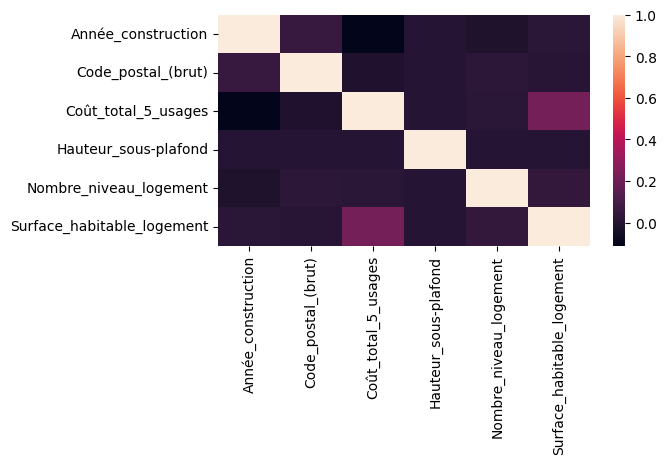

In [147]:
import seaborn as sns

data_quanti = pd.concat([quanti_train, quanti_test])
data_y = pd.concat([y_train, y_test])
data = pd.concat([data_quanti, data_y], axis=1)
sns.heatmap(data_quanti.corr())

On peut observer qu'il y a peu de corrélation entre les variables

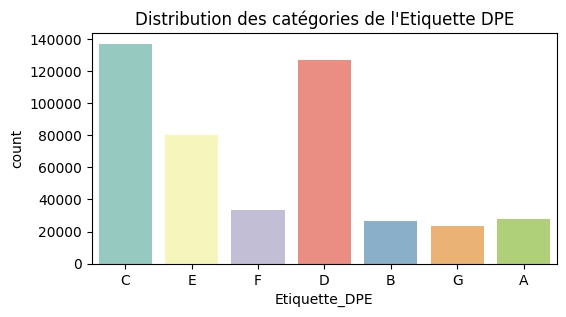

In [148]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [6, 3]

sns.countplot(x='Etiquette_DPE', data=data, palette='Set3')
plt.title('Distribution des catégories de l\'Etiquette DPE')
plt.show()

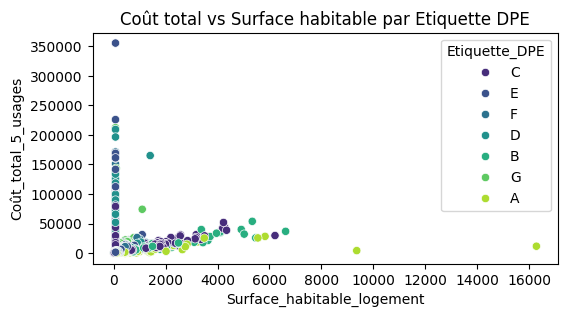

In [149]:
sns.scatterplot(x='Surface_habitable_logement', y='Coût_total_5_usages', hue='Etiquette_DPE', data=data, palette='viridis')
plt.title('Coût total vs Surface habitable par Etiquette DPE')
plt.show()

Lorsqu'on croise le Coût total et la Surface habitable par Etiquette DPE, on observe une sorte de corrélation qui semble croissante. Cela peut suggérer que les logements plus grands tendent à avoir des coûts énergétiques plus élevés. Ce qui semble tout à fait normal car une plus grande surface nécessite souvent plus d’énergie pour le chauffage, la climatisation, et autres usages, ce qui augmente le coût énergétique global.

## Modèle de classification 

### Feature selection

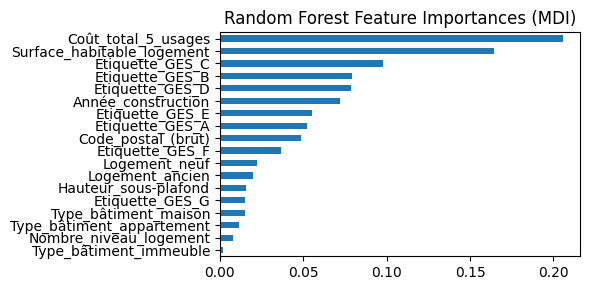

In [152]:
feature_names = rf.feature_names_in_[:20]

mdi_importances = pd.Series(
    rf.feature_importances_[:20], index=feature_names
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, min_samples_split=5, random_state=0, verbose=1)
rf.fit(X_train_mca, y_train)
y_pred = rf.predict(X_test_mca)

In [151]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.97      0.96      0.96      8399
           B       0.91      0.90      0.91      7952
           C       0.94      0.97      0.95     41165
           D       0.90      0.89      0.89     38176
           E       0.87      0.87      0.87     24134
           F       0.85      0.81      0.83     10042
           G       0.89      0.82      0.85      6942

    accuracy                           0.91    136810
   macro avg       0.90      0.89      0.90    136810
weighted avg       0.91      0.91      0.91    136810



La précision globale est de 91%, indiquant que 91% des prédictions totales du modèle sont correctes. Il est performant pour les classes majoritaires (A, B, C, D), mais les performances diminuent légèrement pour les classes minoritaires comme F et G.

In [154]:
new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":200,
                     "Coût_total_5_usages":10000,
                     "Etiquette_GES":"B",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

from pipeline import Pipeline_classification

print("Prédiction de l'étiquette DPE'")
Pipeline_classification(new)

Prédiction de l'étiquette DPE'
['B']


Pour cet exemple de données, le modèle de classification a prédit **l'étiquette B**.

## Modèle de regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, min_samples_split=5, max_depth=None, random_state=0, verbose=1)
rf.fit(X_train_mca[vars], y_train)
y_pred = rf.predict(X_test_mca[vars])

In [160]:
# Avec DPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

MSE: 3193454.9583449326
RMSE: 1787.024050857999
MAE: 270.5596738731614
R²: 0.5586152358463896


Les résultats de performance de notre modèle de regression montrent que le modèle capture une partie importante de la structure des données, mais il reste une marge d'amélioration.

In [161]:
new = pd.DataFrame([{"Année_construction":2024,
                     "Surface_habitable_logement":20,
                     "Etiquette_DPE":"B",
                     "Code_postal_(brut)":35660,
                     "Logement":"neuf",
                     "Type_bâtiment":"maison",
                     "Hauteur_sous-plafond":3,
                     "Nombre_niveau_logement":2
                     }])

Pour ce exemple le modèle de regression a prédit comme conssommation énergétique:

In [162]:
from pipeline import Pipeline_regression

print("Prédiction de la consommation énergétique:")
Pipeline_regression(new)

Prédiction de la consommation énergétique:
[354.84852658]
